# True colour animations with rainfall

* **Products used:** 
[gm_s2_rolling](https://explorer.digitalearth.africa/gm_s2_rolling), [gm_ls8_ls9_annual](https://explorer.digitalearth.africa/products/gm_ls8_ls9_annual), [gm_ls8_annual](https://explorer.digitalearth.africa/gm_ls8_annual), [gm_ls5_ls7_annual](https://explorer.digitalearth.africa/gm_ls5_ls7_annual),
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly), [rainfall_chirps_daily](https://explorer.digitalearth.africa/products/rainfall_chirps_daily)


## Background
It can be informative to visualise true colour imagery of an area through time alongside a variable which contributes to the land surface state, such as rainfall. Inspecting an animated timeseries of a given area through time alongside cumulative rainfall can show how landscape features (vegetation, water bodies etc.) respond to rain events or lack thereof.

This notebook demonstrates how rainfall and true colour imagery data can be assimilated to produce informative animations.

## Description

We can use surface reflectance and CHIRPS rainfall data to produce these animations. Through the DE Africa Sandbox we can integrate these datasets over a time period of interest and align them both temporally and spatially to visualise them synchronously.

The animations are produced in this notebook by following the steps below:

1. Select an area of interest.
2. Load surface reflectance (true colour) imagery.
3. Resample and interpolate imagery to generate a regular timeseries.
4. Load rainfall data.
5. Resample rainfall data to generate a regular timeseries.
6. Define axes and update function for the animation.
7. Run and interpret the animation.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import datetime as dt
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates

from IPython.display import HTML
from datacube.utils.geometry import Geometry
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='animation-rainfall')

create_local_dask_cluster()

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35035 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mickwelli@bigpond.com/proxy/35035/status,
Dashboard: /user/mickwelli@bigpond.com/proxy/35035/status,Workers: 1
Total threads: 2,Total memory: 11.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41425,Workers: 1
Dashboard: /user/mickwelli@bigpond.com/proxy/35035/status,Total threads: 2
Started: Just now,Total memory: 11.21 GiB
Comm: tcp://127.0.0.1:32853,Total threads: 2
Dashboard: /user/mickwelli@bigpond.com/proxy/36491/status,Memory: 11.21 GiB
Nanny: tcp://127.0.0.1:44879,


### Analysis parameters




To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button ![upload_files_icon.png](upload_files_icon.png) in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

The default area is Mosiotunya - the smoke that thunders - (Victoria Falls) on the Zambezi River bordering Zimbabwe and Zambia.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-17.92, lon=25.85, buffer=0.05)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(lon_range, lat_range)

## Load satellite data from datacube

Initially, we will load the rolling geomedian true colour (red, green, blue) bands to visualise changes in the landscape within a recent year. We load a month prior and following the period of interest as it assists in generating a regular timeseries within the year of interest.

In [4]:
# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2022-01-01', '2022-12-31'),
    'resolution': (-20, 20)
}

# Load available data
ds = dc.load(product=['gm_s2_rolling'],
             measurements=['red', 'green', 'blue'],
             group_by='solar_day',
             output_crs='epsg:6933',
             **query)

# Print output data
ds

<xarray.Dataset>
Dimensions:      (time: 14, y: 609, x: 483)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-16T23:59:59.999999 ... 2023-01...
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1257 1299 1223 1177 ... 411 370 357 368
    green        (time, y, x) uint16 1015 1021 964 911 980 ... 665 638 609 611
    blue         (time, y, x) uint16 727 755 684 660 736 ... 397 384 364 359 362
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Interpolation of timeseries

We want to generate an animation for a single calendar year, so we need a regular timeseries with time-steps that match rainfall data. This is generally not available from an analysis-ready dataset as some images will be omitted due to cloud cover, especially in wetter seasons.

To regulate the timeseries, we downsample the temporal resolution using interpolation. This means that we are generating new data, or gap-filling through time, based on the existing data. It is important that this is disclosed to viewers and users because the interpolated data is not observational and is therefore subject to uncertainty.

There are several methods available for interpolation: "linear", "nearest", "zero", "slinear", "quadratic", "cubic", and "polynomial". The method determines the flexibility or 'wiggliness' allowed in the temporal gap-filling. You can try a few different methods below. Further information can be found in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d).

In this case, we generate a timeseries with an image for every two days of the year, giving a dataset with 182 time-steps (approx. = 365/2). This gives a nice smooth animation without placing excessive demand on computation and memory.

In [5]:
ds = ds.resample(time="2D").interpolate("linear").sel(
    time=slice('2022-01-01', '2022-12-31'))

ds

<xarray.Dataset>
Dimensions:      (y: 609, x: 483, time: 183)
Coordinates:
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2022-01-01 2022-01-03 ... 2022-12-31
Data variables:
    red          (time, y, x) float64 1.082e+03 1.139e+03 ... 443.4 443.0
    green        (time, y, x) float64 967.4 978.1 937.1 ... 726.4 682.4 676.7
    blue         (time, y, x) float64 667.5 705.3 644.7 ... 447.3 433.0 429.8
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Load rainfall data

We will load daily rainfall data from CHIRPS and then resample it to sum rainfall every two days, so the temporal resolution matches that of the true-colour imagery. We will also accumulate rainfall across the year using the `cumsum()` function. This enables us to visualise total rainfall, which can be more informative than viewing sporadic rainfall events. However, there are numerous other ways rainfall can be visualised through time which you may like to explore.

A static chart of cumulative annual rainfall is generated below. For the default location of Mosiotunya (Victoria Falls), a distinct dry season through the middle part of the year is evident.

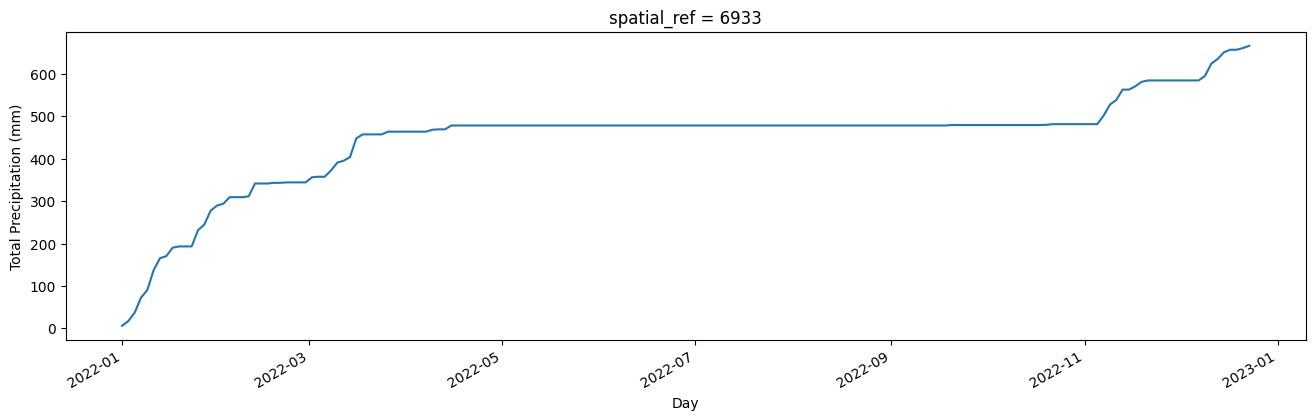

In [6]:
ds_rf_daily = dc.load(product='rainfall_chirps_daily',
                time='2022',
                y = lat_range,
                x = lon_range,
                resolution=(-5000, 5000),
                output_crs='epsg:6933')

ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum().plot(figsize=(16, 4))
plt.xlabel('Day')
plt.ylabel('%s (%s)' % ('Total Precipitation', ds_rf_daily['rainfall'].attrs['units']));

## Define and run animation

The below cell defines and runs the animation through the following steps:
   1. Setting up two sublots.
   2. Defining axis parameters.
   3. Defining an update function.
   4. Running and plotting the animation.
   
You can optionally save the animation to a `.gif` by removing the # before the `ani.save()` command. Note that this closes the plot so you will have to add the # back in and run the cell again to visualise the animation in dynamic form. 

For the default region, we can see that the vegetation is green and waterfall flowing in early months. As the dry period begins, the vegetation senesces, though the flow of the waterfall takes longer to slow. 

In [7]:
# create a figure and axes
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(122)   
ax2 = plt.subplot(121)

ax1.set_title("Cumulative Rainfall")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Precipitation (mm)")

bands=['red', 'green', 'blue']


cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze()/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze())).plot.imshow(rgb='variable', animated = True, robust=True)

def update(num, x, y, line):
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable').squeeze().clip(0,2500)/np.max(
        ds[bands].isel(time=num).to_array().transpose('y','x','variable').squeeze().clip(0,2500))))
    ax2.set_title("Time = " + str(ds[bands].coords['time'].values[(num)])[:12])
    line.set_data(x[:num], y[:num])
    return line,

x = ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum().time
y = ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum()

line, = ax1.plot(x, y)

plt.tight_layout()

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=200, blit=True)
#ani.save('rgb_rain_anim.gif')

plt.close()
HTML(ani.to_html5_video())

# Long term annual rainfall

We can also inspect longer term rainfall patterns alongside annual geomedian images to derive insights into inter-annual patterns in rainfall and landscapes.

## Load geomedians

The Landsat-derived geomedian products allow us to inspect long periods of time. In this case, we load annual images from Landsat 5, 7, 8 and 9 covering the epoch from 1990 - 2021.

In [8]:
ds = dc.load(product=["gm_ls5_ls7_annual", "gm_ls8_annual","gm_ls8_ls9_annual"],
             measurements=['red', 'green', 'blue'],
             x=lon_range,
             y=lat_range,
             dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
             time=("1990", "2021")
             ).compute()
ds

<xarray.Dataset>
Dimensions:      (time: 32, y: 406, x: 322)
Coordinates:
  * time         (time) datetime64[ns] 1990-07-02T11:59:59.999999 ... 2021-07...
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 1008 994 997 1127 ... 1034 1044 1022 974
    green        (time, y, x) uint16 814 798 791 864 988 ... 801 790 789 769 750
    blue         (time, y, x) uint16 562 551 539 580 645 ... 511 505 502 485 472
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Load monthly rainfall

In this animation, our time-steps are annual, so we will generate an annual total rainfall timeseries. We do this by loading annual rainfall and summing values by year.

We will also calculate the rainfall anomaly as this can be a useful way of visualising the relativity of annual rainfall. For this reason we calculate and store the mean and standard deviation in annual rainfall across the entire period.

In [9]:
ds_rf_year = dc.load(product='rainfall_chirps_monthly',
                time=("1990", "2021"),
                y = lat_range,
                x = lon_range,
                resolution=(-5000, 5000),
                dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
                output_crs='EPSG:6933').resample(time='1Y').sum()

# mean across years
rf_mean = ds_rf_year.mean('time').compute()

#calculate annual std dev
rf_std = ds_rf_year.std('time').compute()

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Calculate standardised anomalies

The function below calculates standardised anomalies using the stored mean and standard deviation values from above.

In [10]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_rf_year,
    rf_mean,
    rf_std,
    output_dtypes=[rf_mean.rainfall.dtype],
    dask="allowed"
).compute().mean(['y', 'x']).to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

## Prepare rainfall data

Finally, we collapse the spatial dimensions of the rainfall data to generate a dataframe containing columns for time and annual rainfall volume (mm).

In [11]:
ds_rf_year_1D = ds_rf_year.mean(['y', 'x']).to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

## Define and run animation

The below cell defines and runs the animation through the following steps:
   1. Setting up two sublots.
   2. Defining axis parameters.
   3. Defining an update function.
   4. Running and plotting the animation.
   
You can optionally save the animation to a `.gif` by removing the # before the `ani.save()` command. Note that this closes the plot so you will have to add the # back in and run the cell again to visualise the animation in dynamic form. 

In [12]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=2)

bands=['red', 'green', 'blue']

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.set_xlim((min(mdates.date2num(ds_rf_year_1D.index))), (max(mdates.date2num(ds_rf_year_1D.index))))
ax1.set_ylim(0, max(ds_rf_year_1D.rainfall)+100)
ax1.set_title("Annual Rainfall")
ax1.set_xlabel("Year")
ax1.set_ylabel("Rainfall (mm)")

ax3.set_ylim([-4, 4])
ax3.xaxis_date()
ax3.set_xlim((min(mdates.date2num(ds_rf_year_1D.index))), (max(mdates.date2num(ds_rf_year_1D.index))))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax3.set_title("Rainfall Anomaly")
ax3.set_xlabel("Year")
ax3.set_ylabel("Std Deviations from annual mean")
ax3.axhline(0, color='black', linestyle='--')
    
x = ds_rf_year_1D.index.strftime("%Y")
y = [0] * ds_rf_year_1D.rainfall
                                                                         
x2 = stand_anomalies.index.strftime("%Y")
y2 = [0] * stand_anomalies.rainfall
bars = ax3.bar(x2, y2, align='center', width=80,color=(stand_anomalies.rainfall > 0).map({True: 'g', False: 'brown'}))

bars2 = ax1.bar(x, y, align='center', width=80, color='blue')

cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze(
    ).clip(0,3000)/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze().clip(0,3000))).plot.imshow(rgb='variable', animated = True, robust=True, ax=ax2)

def update(num, x, y, x2, y2, bars, bars2):
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000)/np.max(
        ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000))
    y2[num] = stand_anomalies.rainfall[num]
    bars[num].set_height(y2[num])
    ax2.set_title("Year = " + str(ds[bands].coords['time'].values[(num)])[:4])
    y[num] = ds_rf_year_1D.rainfall[num]
    bars2[num].set_height(y[num])
    return bars2

plt.tight_layout()
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, x2, y2, bars, bars2],
                              interval=400, blit=False, repeat=True)
#ani.save('geom_rain_lt_anim.gif')

plt.close()  

HTML(ani.to_html5_video())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.13


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-07-06'